## **Data Translation Case**
#### A data transformation workflow elaborated by Fernando Herrera Garza
###### _November 2nd, 2023_

### **Introduction**
The following notebook was created with the purpose of inspecting and wrangling the [dataset](sampleData.csv) provided by recruitment team of **Arca Continental** as part of the application processs for the position of Data Translator Analyst. The goal is to transform the dataset in order for it to be propperly analyzed to obtain relevant insights that will answer the following points:

> **1.** Identify the top five customers who placed the most orders in January.
>
> **2.** Determine the most popular productAgrupationID based on the total number of cases ordered.
>
> **3.** Identify the most ordered product ID of each productAgrupationID.
>
> **4.** How does the sales volume vary across different territories?
>
> **5.** Are there any notable patterns or trends in the productAgrupationID with high sales volume?

#### **Dependencies**

In [1]:
%pip install requirements.txt

ERROR: Could not find a version that satisfies the requirement requirements.txt (from versions: none)
HINT: You are attempting to install a package literally named "requirements.txt" (which cannot exist). Consider using the '-r' flag to install the packages listed in requirements.txt
ERROR: No matching distribution found for requirements.txt
You should consider upgrading via the '/Users/macbook/Desktop/Dev/Arca/Application/.env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


#### **Import Packages**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### **Import and Describe Data**

In [3]:
# We can always begin with creating a dataframe from the data and visualizing its shape, dtypes and head.
data = pd.read_csv("sampleData.csv")
print("The dataset consists of {} rows and {} columns".format(*data.shape))
print("")
print("Its fields have the following data types.")
print(data.dtypes)
data.head(10)

The dataset consists of 70393 rows and 6 columns

Its fields have the following data types.
order_date                object
customer                   int64
productAgrupationID      float64
productID                  int64
territory                  int64
product_cases_ordered    float64
dtype: object


,order_date,customer,productAgrupationID,productID,territory,product_cases_ordered
0,2020-01-23T00:00:00.000Z,247474,1431.0,10159,262,28.76
1,2020-01-24T00:00:00.000Z,239611,1626.0,9968,263,28.76
2,2020-01-31T00:00:00.000Z,382014,1202.0,9864,279,28.76
3,2020-01-31T00:00:00.000Z,382014,1202.0,9863,279,28.76
4,2020-01-21T00:00:00.000Z,225565,1202.0,9864,263,28.76
5,2020-01-31T00:00:00.000Z,382014,1202.0,9865,279,28.76
6,2020-01-31T00:00:00.000Z,382014,1202.0,9928,279,28.76
7,2020-01-31T00:00:00.000Z,377848,1418.0,10435,279,28.76
8,2020-01-31T00:00:00.000Z,235365,1194.0,10343,263,28.76
9,2020-01-31T00:00:00.000Z,235365,1194.0,10344,263,28.76


#### **Removing Duplicates**

As a general practice we need to make sure that we are not dealing with duplicate rows and if so, they need to be removed from the dataset in order to avoid bias or inaccuracy in our insights. This can be done with Pandas: using the **duplicated** method and aggregating the resulting Series, we see that there are 10,815 rows that are a duplicate of another row.

In [4]:
print("There are {} duplicate rows in the dataset.".format(data.duplicated().sum()))

There are 10815 duplicate rows in the dataset.


No we can call the **drop_duplicates** method to remove these from the dataset. We can visualize that the amount of rows dropped from 70,393 to X, which is consistent with the previously calculated amount of duplicates.

In [5]:
data.drop_duplicates(inplace=True)
print("There are now {} rows in the dataset.".format(data.shape[0]))

There are now 59578 rows in the dataset.


#### **Inspecting Individual Fields**

Since we have no previous information regarding the structure of some fields such as the Customer ID (we don't know the length it must have), we need to inspect one by one in order to understand how the values behave and what they represent. This way, we can discard suspicious values, reassign the data type or assign a label to the value. This procedure will also allow us to make values such as order_date are within the expected range which corresponds to dates in the month of January. 

> ##### **order_date**

We can see from the description we generated from the dataset, that the order date field is composed by a datetime object formatted according to ISO 8601. The head values don't seem to include values for time rather than zeros, so we can start by inspecting all dates to see if there are any dates with specific time information rather than just the date.


In [6]:
full_dates = data['order_date']
dates = pd.to_datetime(full_dates).dt.date
times = pd.to_datetime(full_dates).dt.time
dates_with_non_zero_time = dates[times != pd.to_datetime('00:00:00').time()].count()
print("The amount of dates with a time different from 00:00:00 is {}".format(dates_with_non_zero_time))

The amount of dates with a time different from 00:00:00 is 0


Since all dates appear to mark the day at midnight and there is not a single date containing specific time information, a new column containing only the date is added to the dataset. This is done in order to have easier to read dates in further visualizations and comparisons.

In [7]:
data.insert(1,'order_date_date',dates)
data.head()

,order_date,order_date_date,customer,productAgrupationID,productID,territory,product_cases_ordered
0,2020-01-23T00:00:00.000Z,2020-01-23,247474,1431.0,10159,262,28.76
1,2020-01-24T00:00:00.000Z,2020-01-24,239611,1626.0,9968,263,28.76
2,2020-01-31T00:00:00.000Z,2020-01-31,382014,1202.0,9864,279,28.76
3,2020-01-31T00:00:00.000Z,2020-01-31,382014,1202.0,9863,279,28.76
4,2020-01-21T00:00:00.000Z,2020-01-21,225565,1202.0,9864,263,28.76


Now, we can visualize the distribution of the dates as a box plot in order to detect the range of values we are working with. Given the dataset description we were provided with, we should expect to see an even distribution of dates within the month of January of 2020, without outliers, assuming the transactions occur uninterrumptedly throughout the month.

Lowest date value: 2020-01-02

Highest date value: 2020-01-31


/var/folders/nv/2ttrxtqn3bq9pxbngrkdlckw0000gn/T/ipykernel_44778/1471570249.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data['order_date_date'],


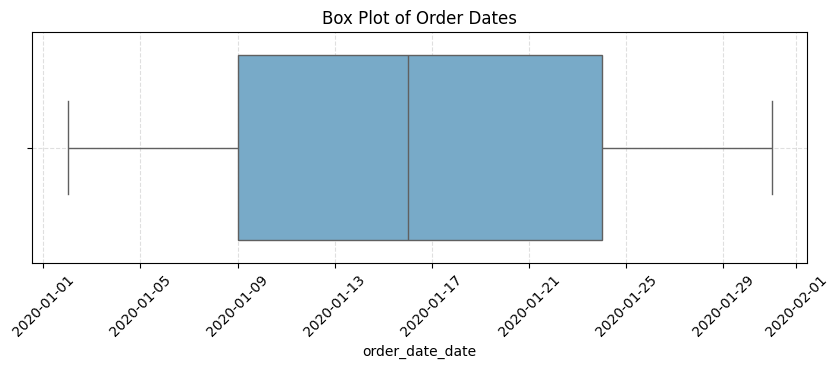

In [153]:
print("Lowest date value: {}".format(dates.min()))
print("")
print("Highest date value: {}".format(dates.max()))

# Plot the order date (date) Box Plot
plt.figure(figsize=(10,3))
sns.boxplot(data=data['order_date_date'],
            orient='h',
            palette='Blues')
plt.grid(True, linestyle='--', alpha=0.4)
plt.title('Box Plot of Order Dates')
plt.xticks(rotation=45)
plt.show()

We can confirm that all date values are within the expected range and uniformly distributed.

> ##### **customer (ID)**

From the head of the dataset we can see that some values of the customer field are composed by 6 digits integer numbers. Nevertheless, assuming all customer ID's are uniformly distributed, we should expect to see a distribution with unknown maximum and minimum values but without outliers since the customer ID's gradually increase as more customers are registered. To visualize this further, we can first extract the customer field as a series and sort it to visualize its first and last values. Then we can generate a boxplot out of the series to confirm if there are any outliers.

Lowest customer ID values
48923    724
31259    724
37270    724
4452     724
16010    724
Name: customer, dtype: int64

Highest customer ID values
36011    10458539
36012    10458539
36013    10458539
17648    10458539
45283    10458539
Name: customer, dtype: int64


/var/folders/nv/2ttrxtqn3bq9pxbngrkdlckw0000gn/T/ipykernel_44778/2700235098.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sorted_customers,


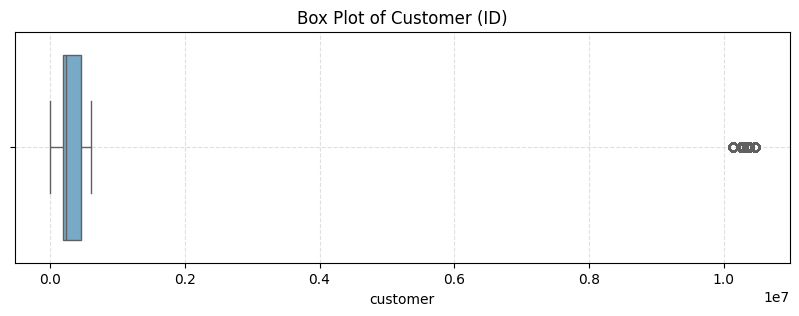

In [72]:
sorted_customers = data['customer'].sort_values()
print("Lowest customer ID values")
print(sorted_customers.head())
print("")
print("Highest customer ID values")
print(sorted_customers.tail())

# Plot the Customer ID Box Plot
plt.figure(figsize=(10,3))
sns.boxplot(data=sorted_customers,
            orient='h',
            palette='Blues')
plt.grid(True, linestyle='--', alpha=0.4)
plt.title('Box Plot of Customer (ID)')
plt.show()

We can see several outliers above the 10,000,000 value mark, which until now means that there might be a select group of customers whose ID is composed of 8 digits. We can further explore this by counting the amount of unique customer ID's over this threshold and checking how many entries correspond to these customers. This could even be represented by a ratio of (amount of orders)/(amount of customers) to then compare it against the same ratio but for customers under the threshold. First, we can list the customer ID's above the threshold and inspect some of the entries that include them.

In [10]:
customers_over_10M = data[data['customer'] > 10000000]['customer'].unique()
print(customers_over_10M)

[10250750 10357744 10285709 10458539 10351421 10142416 10378253]


In [11]:
orders_with_customer_over_10M = data[data['customer'].isin(customers_over_10M)]
orders_with_customer_over_10M


,order_date,order_date_date,customer,productAgrupationID,productID,territory,product_cases_ordered
20,2020-01-31T00:00:00.000Z,2020-01-31,10250750,1328.0,1939,263,28.76
21,2020-01-31T00:00:00.000Z,2020-01-31,10250750,1140.0,10211,263,28.76
22,2020-01-31T00:00:00.000Z,2020-01-31,10250750,1398.0,4183,263,28.76
47,2020-01-31T00:00:00.000Z,2020-01-31,10357744,1228.0,10262,248,28.76
50,2020-01-31T00:00:00.000Z,2020-01-31,10357744,1228.0,10263,248,28.76
...,...,...,...,...,...,...,...
70275,2020-01-31T00:00:00.000Z,2020-01-31,10250750,1412.0,5751,263,28.76
70304,2020-01-21T00:00:00.000Z,2020-01-21,10378253,1121.0,877,252,28.76
70333,2020-01-23T00:00:00.000Z,2020-01-23,10378253,1121.0,877,252,28.76
70365,2020-01-20T00:00:00.000Z,2020-01-20,10250750,1121.0,877,263,28.76


We can now compute the ratio of orders by customer ID's over 10M by the amount of customer ID's over 10M.

In [12]:
outliers_ratio = orders_with_customer_over_10M.shape[0]/len(customers_over_10M)
outliers_ratio

574.4285714285714

The computation can be repeated for the customer ID's under 10M.

In [13]:
customers_under_10M = data[data['customer'] < 10000000]['customer'].unique()
orders_with_customer_under_10M = data[data['customer'].isin(customers_under_10M)]
non_outliers_ratio = orders_with_customer_under_10M.shape[0]/len(customers_under_10M)

print("Average orders per customer with ID above 10000000: {}".format(round(outliers_ratio,2)))
print("Average orders per customer with ID under 10000000: {}".format(round(non_outliers_ratio,2)))

Average orders per customer with ID above 10000000: 574.43
Average orders per customer with ID under 10000000: 597.39


Since both groups of customers show quite similar average orders per customer, we can consider the outliers as valid customer ID's.

> ##### **productAgrupationID (product_agrupation_ID)**

This field is of the data type float64, which may seem strange for a unique identifier. This makes us suspect that there might be one or more non integer value within the column which in case should be discarded. Even if no values are discarded at the end, it is also good practice to cast the data type of that column to integer aswell. Regarding the name of the column, since we are mixing snake and camel case, we can change its name to snake_case just for uniformity.

In [14]:
# Rename the column
column_names = data.columns
column_names

Index(['order_date', 'order_date_date', 'customer', 'productAgrupationID',
       'productID', 'territory', 'product_cases_ordered'],
      dtype='object')

We can also rename the productID columnn at once.

In [15]:
new_column_names = ['order_date', 'order_date_date', 'customer', 'product_agrupation_ID',
       'product_ID', 'territory', 'product_cases_ordered']

data.columns = new_column_names
data.columns

Index(['order_date', 'order_date_date', 'customer', 'product_agrupation_ID',
       'product_ID', 'territory', 'product_cases_ordered'],
      dtype='object')

Now we can check if the column product_agrupation_ID contains any non integer values. We can do this by creating a dummy function that returns the negated result of calling the is_integer() method on its parameter, and then applying this function on the column.

In [16]:
# Dummy function
def is_not_int(value):
    return not value.is_integer()

non_integer_product_agrupation_ID_amount = data["product_agrupation_ID"].apply(is_not_int).sum()
print("The product_agrupation_ID column contains {} non numerical integer values".format(non_integer_product_agrupation_ID_amount))

The product_agrupation_ID column contains 0 non numerical integer values


Since there are no non numerical integer values in the column we can simply just change its data type to int64.

In [17]:
data['product_agrupation_ID'] = data['product_agrupation_ID'].astype(int)
data.head()

,order_date,order_date_date,customer,product_agrupation_ID,product_ID,territory,product_cases_ordered
0,2020-01-23T00:00:00.000Z,2020-01-23,247474,1431,10159,262,28.76
1,2020-01-24T00:00:00.000Z,2020-01-24,239611,1626,9968,263,28.76
2,2020-01-31T00:00:00.000Z,2020-01-31,382014,1202,9864,279,28.76
3,2020-01-31T00:00:00.000Z,2020-01-31,382014,1202,9863,279,28.76
4,2020-01-21T00:00:00.000Z,2020-01-21,225565,1202,9864,263,28.76


It could also be very valuable to inspect for values that only ocurr extremely low times such as only once, because this could indicate an error in the entry. This could be done by using the **value_counts()** method and visualizing the tail values.

In [18]:
data['product_agrupation_ID'].value_counts().tail(10)

product_agrupation_ID
1129    2
1605    2
1615    2
1311    2
1281    1
1455    1
1061    1
1531    1
1429    1
1603    1
Name: count, dtype: int64

We can see 6 product agrupation ID's with a value of one, but since we don't have the list of posible ID's for this field, we can view the complete 6 entries and verify if they have any suspicious or common values.

In [19]:
data[data['product_agrupation_ID'].isin([1281,1455,1061,1531,1429,1603])]

,order_date,order_date_date,customer,product_agrupation_ID,product_ID,territory,product_cases_ordered
2980,2020-01-07T00:00:00.000Z,2020-01-07,465155,1281,6616,252,29.76
14930,2020-01-27T00:00:00.000Z,2020-01-27,467183,1061,6454,252,29.76
25225,2020-01-23T00:00:00.000Z,2020-01-23,466910,1455,4467,252,25.76
37662,2020-01-15T00:00:00.000Z,2020-01-15,162333,1531,3141,289,28.76
50293,2020-01-20T00:00:00.000Z,2020-01-20,377848,1429,5068,279,28.76
54128,2020-01-02T00:00:00.000Z,2020-01-02,157540,1603,3052,289,28.76


None of the values seem suspcious with the current iformation the we have, so we can keep these entries.

> ##### **productID (product_ID)**

The name of this column was just previously changed to camel case. For this field, similarly to the customer ID, we could expect continous values with no outliers.

Lowest product ID value: 778

Highest product ID value: 14903


/var/folders/nv/2ttrxtqn3bq9pxbngrkdlckw0000gn/T/ipykernel_44778/2756875408.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data['product_ID'],


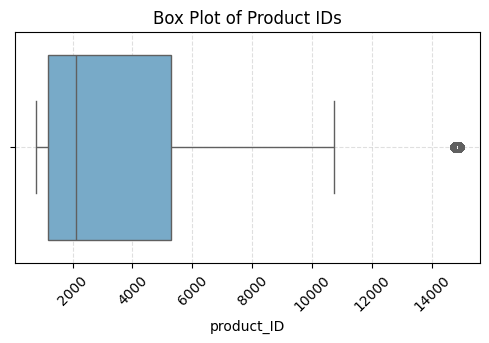

In [73]:
print("Lowest product ID value: {}".format(data['product_ID'].min()))
print("")
print("Highest product ID value: {}".format(data['product_ID'].max()))

# Plot the order date (date) Box Plot
plt.figure(figsize=(6,3))
sns.boxplot(data=data['product_ID'],
            orient='h',
            palette='Blues')
plt.grid(True, linestyle='--', alpha=0.4)
plt.title('Box Plot of Product IDs')
plt.xticks(rotation=45)
plt.show()

We can see some product ID's outlying above the 14000 mark. Similar to what we did with the customer ID's, we can inspect the amount of outliers and determine and how many entries have these values in the product_ID field. We can then compare the proportion against the product ID's under 14000.

In [21]:
product_IDs_over_14K = data[data['product_ID'] > 14000]['product_ID'].unique()
orders_with_product_ID_over_14K = data[data['product_ID'].isin(product_IDs_over_14K)]
outliers_ratio = orders_with_product_ID_over_14K.shape[0]/len(product_IDs_over_14K)

product_IDs_under_14K = data[data['product_ID'] < 14000]['product_ID'].unique()
orders_with_product_ID_under_14K = data[data['product_ID'].isin(product_IDs_under_14K)]
non_outliers_ratio = orders_with_product_ID_under_14K.shape[0]/len(product_IDs_under_14K)

print("Average orders per customer with ID above 14000: {}".format(round(outliers_ratio,2)))
print("Average orders per customer with ID under 14000: {}".format(round(non_outliers_ratio,2)))

Average orders per customer with ID above 14000: 25.7
Average orders per customer with ID under 14000: 106.07


In this case, the proportions are quite different, which tells us that products with an ID above 14000 might be more rare or more specific, therefore involved in less transactions. Nevertheless, we can view some entries that include these product ID's and see if we notice something strange.

In [22]:
orders_with_product_ID_over_14K

,order_date,order_date_date,customer,product_agrupation_ID,product_ID,territory,product_cases_ordered
71,2020-01-20T00:00:00.000Z,2020-01-20,49835,1127,14897,245,28.76
103,2020-01-23T00:00:00.000Z,2020-01-23,247474,1431,14837,262,28.76
122,2020-01-31T00:00:00.000Z,2020-01-31,244274,1431,14837,263,28.76
167,2020-01-31T00:00:00.000Z,2020-01-31,444292,1543,14870,246,28.76
169,2020-01-21T00:00:00.000Z,2020-01-21,464057,1543,14870,246,28.76
...,...,...,...,...,...,...,...
70094,2020-01-18T00:00:00.000Z,2020-01-18,605394,1521,14789,263,28.76
70109,2020-01-18T00:00:00.000Z,2020-01-18,228455,1431,14837,263,28.76
70111,2020-01-14T00:00:00.000Z,2020-01-14,97717,1431,14837,301,29.76
70131,2020-01-18T00:00:00.000Z,2020-01-18,444292,1461,14898,246,32.76


At first glance we can not spot any strange behavior compared to what we have previously seen, and given that those product ID's still have in average 25 transactions each, we can consider them non-suspicious and keep those entries in the data set.

> ##### **territory**

This field represents the region in which the sale took place. An example we have is that the city of Monterrey is represented by the integer 245. We can further visualize the values this field takes using a box plot aswell. Intuitively and thinking about [the company's presence](https://www.arcacontal.com/divisiones-operativas/bebidas-m%C3%A9xico.aspx) in 14 Mexican states and several other countries, this field might have a less broader amount of unique values compared to the rest of the fields. Therefore, obtaining the amount of unique territories could be very useful to make sense of what these territory values actually mean.


Lowest territory value: 245

Highest territory ID value: 316

Distinct territories: 20


/var/folders/nv/2ttrxtqn3bq9pxbngrkdlckw0000gn/T/ipykernel_44778/1444178975.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data['territory'],


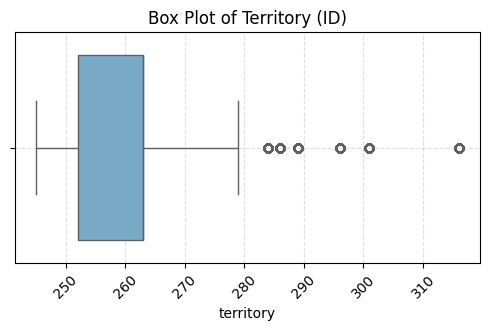

In [74]:
print("Lowest territory value: {}".format(data['territory'].min()))
print("")
print("Highest territory ID value: {}".format(data['territory'].max()))
print("")
print("Distinct territories: {}".format(len(data['territory'].unique())))

# Plot the order date (date) Box Plot
plt.figure(figsize=(6,3))
sns.boxplot(data=data['territory'],
            orient='h',
            palette='Blues')
plt.grid(True, linestyle='--', alpha=0.4)
plt.title('Box Plot of Territory (ID)')
plt.xticks(rotation=45)
plt.show()

First of all, we can see that out of the 20 possible territory values, the upper 6 are statistically considered as outliers, leaving 14 territories as non-outliers, matching the presence of the company in the Mexican states. 

We can also perform the same ratio analysis to determine how many average orders took place in the outlier territories.

In [24]:
territories_over_280 = data[data['territory'] > 280]['territory'].unique()
orders_with_territory_over_280 = data[data['territory'].isin(territories_over_280)]
outliers_ratio = orders_with_territory_over_280.shape[0]/len(territories_over_280)

territories_under_280 = data[data['territory'] < 280]['territory'].unique()
orders_with_territory_under_280 = data[data['territory'].isin(territories_under_280)]
non_outliers_ratio = orders_with_territory_under_280.shape[0]/len(territories_under_280)

print("Average orders per territory with value above 280: {}".format(round(outliers_ratio,2)))
print("Average orders per territory with value under 280: {}".format(round(non_outliers_ratio,2)))

Average orders per territory with value above 280: 1321.83
Average orders per territory with value under 280: 3689.07


Both ratios show a high average amount of orders per territory, but since there are in average significantly less orders in the outlier territories, we could deduce that this due to the company having a stronger salesforce in the Mexican territory rather than abroad. It could still be beneficial to deepen our analysis in the territory group above 280, iterating over each one checking if there is a territory with suspiciously low orders.

In [25]:
for territory in territories_over_280:
    amount_of_orders = data[data['territory'] == territory].shape[0]
    print("Territory {} has {} associated orders.".format(territory, amount_of_orders))

Territory 316 has 2401 associated orders.
Territory 301 has 1816 associated orders.
Territory 284 has 577 associated orders.
Territory 296 has 1119 associated orders.
Territory 286 has 1166 associated orders.
Territory 289 has 852 associated orders.


They all seem to have a low but significant amount of orders so we could most safely keep them in our dataset.

Now, asuming that the non-outlier territories correspond to the Mexican state and considering that code 245 corresponds to Monterrey (Nuevo León), we can distribute the other 13 states per each code from 245 until before 280 as they appear in the previously attached link (placing Nuevo León first to match 245):

**Nuevo León, Tamaulipas, ~~Nuevo León~~, Coahuila, San Luis Potosí, Aguascalientes, Zacatecas, Chihuahua, Durango, Sonora, Baja California Norte, Baja California Sur, Sinaloa, Jalisco and Colima.**

We will create a dictionary to establish this relationship.

In [26]:
region = {}
mexican_states = ["Nuevo León", "Tamaulipas", "Coahuila", "San Luis Potosí", "Aguascalientes", "Zacatecas", "Chihuahua", "Durango", "Sonora", "Baja California Norte", "Baja California Sur", "Sinaloa", "Jalisco", "Colima"]
for idx, territory in enumerate(sorted(territories_under_280)):
    region[territory] = mexican_states[idx]
region

{245: 'Nuevo León',
 246: 'Tamaulipas',
 247: 'Coahuila',
 248: 'San Luis Potosí',
 250: 'Aguascalientes',
 251: 'Zacatecas',
 252: 'Chihuahua',
 262: 'Durango',
 263: 'Sonora',
 264: 'Baja California Norte',
 265: 'Baja California Sur',
 267: 'Sinaloa',
 268: 'Jalisco',
 279: 'Colima'}

Regarding the remaining 6 regions, we can see that [in the USA](https://www.arcacontal.com/divisiones-operativas/bebidas-estados-unidos.aspx) there is presence in Texas, New Mexico, Oklahoma and Arkansas, whilst [in South America](https://www.arcacontal.com/divisiones-operativas/bebidas-sudam%C3%A9rica.aspx) there is presence in Argentina, Ecuador and Perú. This adds up to 7 but for simplification we can ignore Arkansas since it is the entitiy with the least territorial extension out of the seven. We could even list the remaining 6 entities by territory and define the relationship with the 6 outliers matching the amount of orders in descending order with the territory extension.

**In order of territory we have:** 
1. Argentina
2. Peru
3. Texas
4. Ecuador
5. Oklahoma
6. New Mexico

**Matching:**
1. Territory 316: 2401 associated orders.
2. Territory 301: 1816 associated orders.
3. Territory 296: 1119 associated orders.
4. Territory 286: 1166 associated orders.
5. Territory 289: 852 associated orders.
6. Territory 284: 577 associated orders.

We can manually create append this information to the dictionary containing the relationship between the territory and the Mexican states previously defined.

In [27]:
abroad_region = {316:"Argentina",
                301:"Peru",
                296:"Texas",
                286:"Ecuador",
                289:"Oklahoma",
                284:"New Mexico"}

regions = region.update(abroad_region)
region

{245: 'Nuevo León',
 246: 'Tamaulipas',
 247: 'Coahuila',
 248: 'San Luis Potosí',
 250: 'Aguascalientes',
 251: 'Zacatecas',
 252: 'Chihuahua',
 262: 'Durango',
 263: 'Sonora',
 264: 'Baja California Norte',
 265: 'Baja California Sur',
 267: 'Sinaloa',
 268: 'Jalisco',
 279: 'Colima',
 316: 'Argentina',
 301: 'Peru',
 296: 'Texas',
 286: 'Ecuador',
 289: 'Oklahoma',
 284: 'New Mexico'}

Now that we have a translation for each one of the posible territory values, we can apply a lambda function to the territory column, that accesses the region dictionary passing each territory value to create a new column called region.

In [28]:
data['region'] = data['territory'].apply(lambda territory: region[territory])
data.head()

,order_date,order_date_date,customer,product_agrupation_ID,product_ID,territory,product_cases_ordered,region
0,2020-01-23T00:00:00.000Z,2020-01-23,247474,1431,10159,262,28.76,Durango
1,2020-01-24T00:00:00.000Z,2020-01-24,239611,1626,9968,263,28.76,Sonora
2,2020-01-31T00:00:00.000Z,2020-01-31,382014,1202,9864,279,28.76,Colima
3,2020-01-31T00:00:00.000Z,2020-01-31,382014,1202,9863,279,28.76,Colima
4,2020-01-21T00:00:00.000Z,2020-01-21,225565,1202,9864,263,28.76,Sonora


> ##### **product_cases_ordered**

This final field corresponds to the amount of cases of the product that were ordered in every sale. What grabs our attention at first glance is that the values seem to be represented with floating points, while it only makes sense to picture cases as units (integers). We can visualize the distribution of these values using a boxplot too.

Least product cases ordered: 2.7600000000000016

Most product cases ordered: 519.76


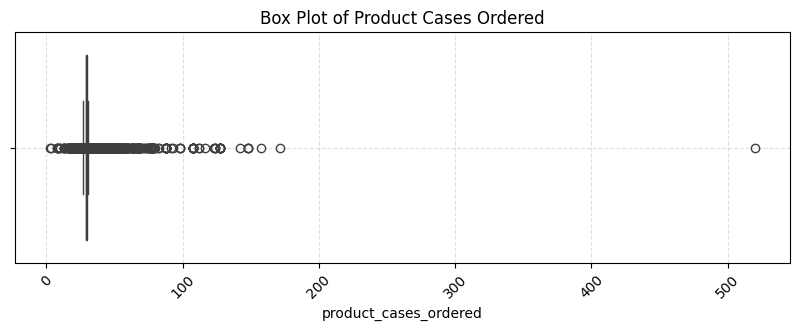

In [77]:
print("Least product cases ordered: {}".format(data['product_cases_ordered'].min()))
print("")
print("Most product cases ordered: {}".format(data['product_cases_ordered'].max()))

# Plot the order date (date) Box Plot
plt.figure(figsize=(10,3))
sns.boxplot(data=data['product_cases_ordered'],
            orient='h')
plt.grid(True, linestyle='--', alpha=0.4)
plt.title("Box Plot of Product Cases Ordered")
plt.xticks(rotation=45)
plt.show()

From the previous plot we can obtain 3 main takeaways:
1. There are some negative values that need to be rejected from our data.
2. The amount of sold cases is **highly** concentrated at about 30.
3. There was a transaction that registered more that 500 sold cases.

The last point does not necesarilly imply a wrong data input. We have little information to determine whether this is the case. Perhaps we can just inspect the full row and keep it in mind in case the results appear to be biased by this specific datapoint later on.

In [30]:
data[data['product_cases_ordered'] > 500]

,order_date,order_date_date,customer,product_agrupation_ID,product_ID,territory,product_cases_ordered,region
42451,2020-01-29T00:00:00.000Z,2020-01-29,466910,1121,877,252,519.76,Chihuahua


To deal with the negative data points, we can keep the columns with values greater than 0.

In [31]:
data = data[data['product_cases_ordered'] > 0]
data

,order_date,order_date_date,customer,product_agrupation_ID,product_ID,territory,product_cases_ordered,region
0,2020-01-23T00:00:00.000Z,2020-01-23,247474,1431,10159,262,28.76,Durango
1,2020-01-24T00:00:00.000Z,2020-01-24,239611,1626,9968,263,28.76,Sonora
2,2020-01-31T00:00:00.000Z,2020-01-31,382014,1202,9864,279,28.76,Colima
3,2020-01-31T00:00:00.000Z,2020-01-31,382014,1202,9863,279,28.76,Colima
4,2020-01-21T00:00:00.000Z,2020-01-21,225565,1202,9864,263,28.76,Sonora
...,...,...,...,...,...,...,...,...
70387,2020-01-21T00:00:00.000Z,2020-01-21,50733,1499,3367,245,28.76,Nuevo León
70388,2020-01-07T00:00:00.000Z,2020-01-07,240204,1121,877,263,28.76,Sonora
70390,2020-01-07T00:00:00.000Z,2020-01-07,241174,1121,877,263,28.76,Sonora
70391,2020-01-08T00:00:00.000Z,2020-01-08,221231,1121,877,263,28.76,Sonora


Now, as all of the questions to be answered depend on a comparative analysis, we could either linearly adjust the whole product_cases_ordered column by a certain factor and then cast the values to integer, or just leave them as they are. We choose the first option to have friendlier values to visualize and interpret further on. There is a third option which is to directly just round the values, but if they happen to proportionally represent something else when it comes to the product cases, rounding will affect this proportion.

We can first visualize some of the values contained in this column:

In [32]:
sorted(data['product_cases_ordered'].unique())

[2.7600000000000016,
 3.7600000000000016,
 7.760000000000002,
 8.760000000000002,
 9.760000000000002,
 12.760000000000002,
 14.760000000000002,
 15.760000000000002,
 16.76,
 17.76,
 18.76,
 19.76,
 20.76,
 21.76,
 22.76,
 23.76,
 24.01,
 24.76,
 25.76,
 26.76,
 26.761000000000003,
 26.843,
 26.885,
 26.927000000000003,
 27.01,
 27.093,
 27.094,
 27.135,
 27.177000000000003,
 27.259,
 27.26,
 27.302000000000003,
 27.343,
 27.360000000000003,
 27.385,
 27.426,
 27.427000000000003,
 27.468,
 27.51,
 27.552000000000003,
 27.593,
 27.635,
 27.66,
 27.677000000000003,
 27.718,
 27.732000000000003,
 27.739,
 27.802000000000003,
 27.843,
 27.860000000000003,
 27.885,
 27.927000000000003,
 27.968,
 28.01,
 28.052000000000003,
 28.093,
 28.094,
 28.135,
 28.16,
 28.218,
 28.26,
 28.261000000000003,
 28.302000000000003,
 28.385,
 28.426,
 28.427000000000003,
 28.428,
 28.468,
 28.51,
 28.593,
 28.595,
 28.759,
 28.76,
 28.762,
 28.885,
 29.01,
 29.092,
 29.26,
 29.425,
 29.43,
 29.51,
 29.635,
 2

It appears to be safe to adjust the whole column by a factor of 100 and then cast it to integer to get rid of 2 decimal places which appear at the head and the tail fo the possible values.

In [33]:
data['product_cases_ordered_adjusted'] = (data['product_cases_ordered']*100).astype(int)
data['product_cases_ordered_adjusted'].unique()

array([ 2876,  2801,  2809,  2792,  2788,  2976,  2826,  2816,  2813,
        2851,  3176,  3276,  3076,  3776,  3376,  2901,  4276,  7776,
        2842,  9776,  4176,  2763,  3576,  2859,  3476,  5276,  4776,
        3676,  3876,  4576,  5776,  3976,  2759,  2786,  2875,  2767,
        5676,  2926,  3026,  6776,  2576,  2751,  2676,  3151,  2771,
        2726,  2709,  2476,  2796,  4676,  4376,  1476,  1676,  2076,
        5976,  4076,   976,  1976,  2276,  6276,  1876,  2176,  4976,
        2742,  2888,  5376, 10776,  5176,  6576,  2738,  6076,  2376,
        2734,  2942,  3001,  3526,  2951,  7876,  2701,  2725,  2755,
        6376,  8776,  5476,  1576,  1276,  1776,  9176,  6476, 17176,
       15776,  2784,  7176,  2830,  2684,  2717,  5576,  7976, 12376,
        2773,  5076,  8176,  2943, 11676,  6976,  2963,  2780,  4876,
        4476, 12776,  2975,   776,  2713, 51976,   876,  7476,  7576,
        2909,  2821,  2846, 12276,  6676,   376,  2805,  2401,  2736,
        2766, 14776,

We can see that the values were propperly adjusted, and maybe they are too big for performing a single variable analysis like checking on the amount of sales for a single territory or customer, but to compare between variables it should work well, since we are respecting any possible proportion the original values might have represented. 

**This approach ignores the posibility of there being an entry error that adds random decimals to the product_cases_ordered column.**

### **Analysis**

Now that the data is clean, we can start performing our visualization analysis in order to answer the stated questions.

> **5.** Are there any notable patterns or trends in the productAgrupationID with high sales volume?

> #### **Identify the top five customers who placed the most orders in January.**
 
This can be obtained by grouping the dataframe by customer (ID) and aggregating by product_cases_ordered_adjusted.

In [136]:
most_orders_by_customer = data.groupby('customer')['product_cases_ordered_adjusted'].sum().sort_values(ascending=False).to_frame().reset_index().head(5)
most_orders_by_customer

,customer,product_cases_ordered_adjusted
0,247474,2960167
1,488882,2799118
2,49295,2735736
3,214634,2652695
4,262320,2506143


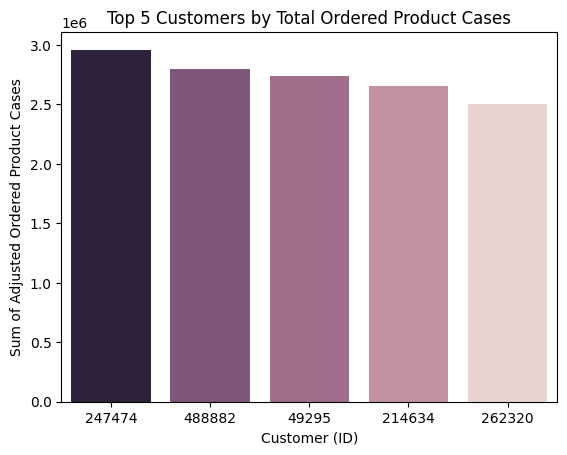

In [137]:
plt.Figure(figsize=(6,6))
sns.barplot(data=most_orders_by_customer,
            x='customer',
            y='product_cases_ordered_adjusted',
            order=most_orders_by_customer['customer'],
            hue='product_cases_ordered_adjusted',
            legend=False)
plt.title("Top 5 Customers by Total Ordered Product Cases")
plt.xlabel("Customer (ID)")
plt.ylabel("Sum of Adjusted Ordered Product Cases")
plt.show()

> #### **Determine the most popular productAgrupationID based on the total number of cases ordered.**

Similar to the previous question, this can be obtained by grouping by product_agrupation_ID and aggregating by product_cases_ordered_adjusted.

In [142]:
most_orders_by_product_agrupation_ID = data.groupby('product_agrupation_ID')['product_cases_ordered_adjusted'].sum().sort_values(ascending=False).to_frame().reset_index().head(5)
most_orders_by_product_agrupation_ID

,product_agrupation_ID,product_cases_ordered_adjusted
0,1121,5715184
1,1104,5160877
2,1123,4670763
3,1103,4528110
4,1202,4366794


We can see that the most popular product agrupation ID was **1121**.
We can further visualize this result by plotting another barplot with the top 5 most popular product agrupation IDs.

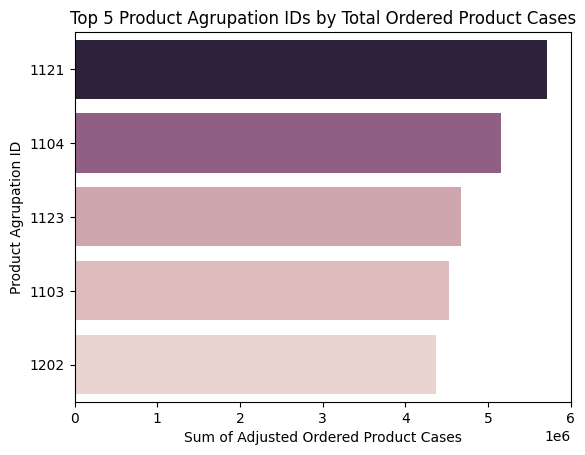

In [149]:
plt.Figure(figsize=(6,6))
sns.barplot(data=most_orders_by_product_agrupation_ID,
            y='product_agrupation_ID',
            x='product_cases_ordered_adjusted',
            order=most_orders_by_product_agrupation_ID['product_agrupation_ID'],
            hue='product_cases_ordered_adjusted',
            orient='h',
            legend=False)
plt.title("Top 5 Product Agrupation IDs by Total Ordered Product Cases")
plt.xlabel("Sum of Adjusted Ordered Product Cases")
plt.ylabel("Product Agrupation ID")
plt.show()

> #### **Identify the most ordered product ID of each productAgrupationID.**

To obtain this information, we can group the dataset by product_agrupation_ID and apply a lambda function on agregation to exctract the first mode. This dataframe can be individually exported to csv to be easily visualized using Tableau.

In [227]:
most_ordered_products_by_agrupation_ID = data.groupby('product_agrupation_ID')['product_ID'].apply(lambda x: x.mode().iloc[0]).reset_index()
most_ordered_products_by_agrupation_ID.to_csv('mostOrderedProductByProductAgrupationId.csv')
most_ordered_products_by_agrupation_ID


,product_agrupation_ID,product_ID
0,1021,3996
1,1023,4205
2,1025,4163
3,1027,4341
4,1037,1297
...,...,...
218,1626,9968
219,1628,9969
220,1629,10139
221,1631,9972


> #### **How does the sales volume vary across different territories?**

For this analysis, three map visualizations were generated using Tableau for the territories in Mexico, territories in USA and territories in South America. An aditional pie chart was included to compare between all regions, regardless of their country.

> #### **Are there any notable patterns or trends in the productAgrupationID with high sales volume?**

In order to answer this questions, perhaps the most straight forward way is by generating multivariable visuals in Tableau, grouping and sorting product agrupation ID's by sales volumes, and seeing the influence of other variables such as order date and product ID.

### **Data Exporting**

Finally, the dataset can be exported to csv to further being visualized through applications like Tableau.

In [150]:
data.to_csv('sampleDataWrangled.csv')